# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print("\n################################################################################\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Thu Dec  8 23:11:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    54W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## System Setup

In [3]:
# Transformers installation
!pip install transformers datasets

# The Evaluate library provides a simple accuracy function
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 451 kB 92.8 MB/s 
     |████████████████████████████████| 7.6 MB 82.2 MB/s 
     |████████████████████████████████| 182 kB 97.2 MB/s 
     |████████████████████████████████| 132 kB 97.0 MB/s 
     |████████████████████████████████| 212 kB 99.0 MB/s 
     |████████████████████████████████| 127 kB 96.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 817 kB/s 


In [4]:
!pip install gputil
!pip install psutil
!pip install humanize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=8821fe9a169cb5457bee3423c6f264cd4b02d57b663c31148fa713bccdef0517
  Stored in directory: /root/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

## Other

In [6]:
import numpy as np
import evaluate
import torch
from datasets import load_dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import ElectraTokenizer, ElectraForSequenceClassification, TrainingArguments, Trainer
from transformers import get_linear_schedule_with_warmup, XLNetForSequenceClassification

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pd.options.display.max_colwidth = 1000
pd.set_option('display.expand_frame_repr', False)

In [7]:
TOKEN_MAX_LENGTH = 256
BATCH_SIZE = 4
EPOCHS = 4
LEARNING_RATE = 1e-5
SEED_VALUE = 42
EVALUATE_AFTER_EPOCH = False

In [8]:
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)

## Parameters

In [95]:
CLEAN_MODEL_PATH = "/content/drive/MyDrive/storage/other/saved_models/imdb_electra-base-emotion_FT_DEF.ckpt"
VICTIM_MODEL_PATH = "/content/drive/MyDrive/storage/other/saved_models/victims/victim_electra-base-emotion_49.ckpt"
ATTACK_SETUP_PATH = "/content/drive/MyDrive/storage/other/saved_models/victims/attack_setup_electra-base-emotion_2.0.npy"
VICTIM_INDEX = 49
SAVE_FOLDER = "/content/drive/MyDrive/storage/plots"

In [11]:
!mkdir -p "/content/drive/MyDrive/storage/plots"

# Dataset Preparation

In [12]:
# IMDB dataset from https://huggingface.co/datasets/imdb
dataset = load_dataset("imdb", split="test")

eval_dataset = dataset.shuffle(seed=SEED_VALUE)
print("Eval dataset positive: {}/{}".format(np.sum(eval_dataset['label']), eval_dataset.num_rows))

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.
Eval dataset positive: 12500/25000


In [13]:
tokenizer = ElectraTokenizer.from_pretrained("bhadresh-savani/electra-base-emotion")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=TOKEN_MAX_LENGTH)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/336 [00:00<?, ?B/s]

In [14]:
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

In [15]:
tokenized_eval_dataset = tokenized_eval_dataset.remove_columns(["text"])
tokenized_eval_dataset = tokenized_eval_dataset.rename_column("label", "labels")
tokenized_eval_dataset.set_format("torch")

eval_dataloader = DataLoader(tokenized_eval_dataset, batch_size=BATCH_SIZE)

# Reloading Models

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [17]:
clean_model = ElectraForSequenceClassification.from_pretrained(
    "bhadresh-savani/electra-base-emotion",
    output_hidden_states=True,
    output_attentions=True,
    num_labels=2,
    ignore_mismatched_sizes=True
)
clean_model.load_state_dict(torch.load(CLEAN_MODEL_PATH, map_location=device))

Downloading:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at bhadresh-savani/electra-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([6, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [18]:
victim_model = ElectraForSequenceClassification.from_pretrained(
    "bhadresh-savani/electra-base-emotion",
    output_hidden_states=True,
    output_attentions=True,
    num_labels=2,
    ignore_mismatched_sizes=True
)
victim_model.load_state_dict(torch.load(VICTIM_MODEL_PATH, map_location=device))

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at bhadresh-savani/electra-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([6, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [19]:
clean_model.to(device)
victim_model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=768, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [20]:
setup_params = np.load(ATTACK_SETUP_PATH, allow_pickle=True).item()

labels_t = setup_params["labels_t"]
tst_inds = np.where(labels_t == VICTIM_INDEX)[0]

# Helper Functions

In [60]:
# dim_reducer = TSNE(n_components=2)
dim_reducer = PCA(n_components=2)

def visualize_layerwise_embeddings(hidden_states, masks, ys, cl_inds, title, filename, xlim=None, ylim=None, t_palette=["red"]):
    print('visualize_layerwise_embeddings for', title)
    global dim_reducer
    fig = plt.figure(figsize=(9, 6))
    if xlim:
      plt.xlim(xlim)
    if ylim:
      plt.ylim(ylim)
    ys = ys.reshape(-1)
    layer_i = 11

    layer_hidden_states = hidden_states[layer_i].cpu()
    averaged_layer_hidden_states = torch.div(layer_hidden_states, masks.sum(dim=1,keepdim=True))
    layer_dim_reduced_vectors = dim_reducer.fit_transform(averaged_layer_hidden_states.numpy())
    df = pd.DataFrame.from_dict({'x':layer_dim_reduced_vectors[:,0],'y':layer_dim_reduced_vectors[:,1],'label':ys})
    df.label = df.label.astype(int)
    df_base = df.loc[~df.index.isin(cl_inds)]
    df_cl = df.loc[df.index.isin(cl_inds)]

    df_base[df_base.label == 1]

    sns.scatterplot(data=df_base,x='x',y='y',hue='label', alpha=0.3, marker="^")
    sns.scatterplot(data=df_cl,x='x',y='y',hue='label', palette=t_palette)
    fig.suptitle(title)

    plt.savefig(f'{SAVE_FOLDER}/{filename}.png',format='png',pad_inches=0)
    print()

In [22]:
metric = evaluate.load("accuracy")
def evaluate_model(e_model, e_dataloader):
  e_progress_bar = tqdm(range(len(e_dataloader)))
  e_model.eval()
  e_total_loss = 0
  e_count = 0
  for batch in e_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = e_model(**batch)

      e_logits = outputs.logits
      e_count += batch['labels'].shape[0]
      e_total_loss += outputs.loss.detach() * batch['labels'].shape[0]
      predictions = torch.argmax(e_logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])
      e_progress_bar.update(1)

  e_acc = metric.compute()['accuracy']
  e_loss = e_total_loss / e_count
  return e_acc, e_loss

In [54]:
def visualize_model(v_model, v_dataloader):
  print("  Visualizing...")
  v_progress_bar = tqdm(range(len(v_dataloader)))
  v_model.eval()
  mem_report()

  v_total_loss = 0
  v_count = 0
  v_masks = torch.zeros(0, TOKEN_MAX_LENGTH)
  v_ys = torch.zeros(0,1)
  v_hidden_states = None
  all_preds = []
  for batch in v_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = v_model(**batch)

      v_logits = outputs.logits
      v_count += batch['labels'].shape[0]
      v_total_loss += outputs.loss.detach() * batch['labels'].shape[0]

      hidden_states = outputs.hidden_states[1:]
      v_masks = torch.cat([v_masks, batch["attention_mask"].cpu()])
      v_ys = torch.cat([v_ys, batch['labels'].cpu().view(-1,1)])

      if type(v_hidden_states) == type(None):
          v_hidden_states = tuple(layer_hidden_states.sum(dim=1) for layer_hidden_states in hidden_states)
      else:
          v_hidden_states = tuple(torch.cat([layer_hidden_state_all,layer_hidden_state_batch.sum(dim=1)]) for layer_hidden_state_all,layer_hidden_state_batch in zip(v_hidden_states,hidden_states))

      predictions = torch.argmax(v_logits, dim=-1)
      all_preds = np.concatenate((all_preds, predictions.cpu().detach().numpy()))
      metric.add_batch(predictions=predictions, references=batch["labels"])
      v_progress_bar.update(1)

  v_loss = v_total_loss / v_count
  v_acc = metric.compute()['accuracy']

  torch.cuda.empty_cache()
  mem_report()  

  return v_acc, v_loss, v_hidden_states, v_masks, v_ys, all_preds

# Visualize

## Clean Model

In [55]:
acc, loss, hidden_states, masks, ys, predictions = visualize_model(clean_model, eval_dataloader)
print(acc, loss)

  Visualizing...


  0%|          | 0/6250 [00:00<?, ?it/s]

CPU RAM Free: 84.8 GB
GPU 0 ... Mem Free: 38300MB / 40536MB | Utilization   6%
CPU RAM Free: 84.9 GB
GPU 0 ... Mem Free: 37852MB / 40536MB | Utilization   7%
0.89844 tensor(0.2603, device='cuda:0')


In [56]:
plot_values = {}
plot_values["hidden_states"] = hidden_states
plot_values["masks"] = masks
plot_values["ys"] = ys
plot_values["predictions"] = predictions
save_path = "{}/{}".format(SAVE_FOLDER, "electra_clean_plot_values")
np.save(save_path, plot_values)

In [57]:
save_path = "{}/{}.npy".format(SAVE_FOLDER, "electra_clean_plot_values")
plot_values = np.load(save_path, allow_pickle=True).item()
c_hidden_states = plot_values["hidden_states"]
c_masks = plot_values["masks"]
c_ys = plot_values["ys"]
c_predictions = plot_values["predictions"]

visualize_layerwise_embeddings for Electra Clean - Ground Truth



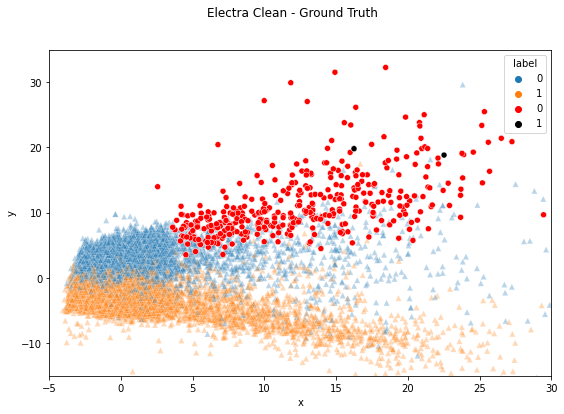

In [85]:
# ys_change = torch.clone(ys)
# ys_change[tst_inds] = 2

# visualize_layerwise_embeddings(hidden_states, masks, ys_change, tst_inds, 
                              #  "Electra Clean", "electra_model_clean")

# torch.cuda.empty_cache()
# mem_report()

visualize_layerwise_embeddings(c_hidden_states, c_masks, c_ys.numpy(), tst_inds, 
                               "Electra Clean - Ground Truth", "electra_model_clean_labels",
                               xlim=[-5, 30], ylim=[-15, 35],
                               t_palette=["red", "black"])

visualize_layerwise_embeddings for Electra Clean - Predictions



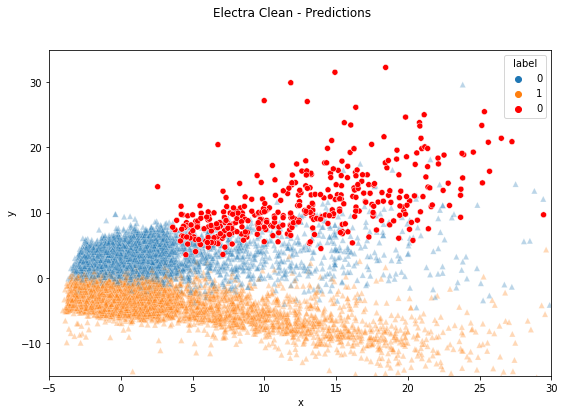

In [84]:
visualize_layerwise_embeddings(c_hidden_states, c_masks, c_predictions, tst_inds, 
                               "Electra Clean - Predictions", "electra_model_clean_pred",
                               xlim=[-5, 30], ylim=[-15, 35],
                               t_palette=["red"])

## Victim Model

In [64]:
acc_victim, loss_victim, hidden_states_victim, masks_victim, ys_victim, predictions_victim = visualize_model(victim_model, eval_dataloader)
print(acc_victim, loss_victim)

  Visualizing...


  0%|          | 0/6250 [00:00<?, ?it/s]

CPU RAM Free: 84.7 GB
GPU 0 ... Mem Free: 37988MB / 40536MB | Utilization   6%
CPU RAM Free: 84.7 GB
GPU 0 ... Mem Free: 37554MB / 40536MB | Utilization   7%
0.89508 tensor(0.2747, device='cuda:0')


In [65]:
plot_values = {}
plot_values["hidden_states"] = hidden_states_victim
plot_values["masks"] = masks_victim
plot_values["ys"] = ys_victim
plot_values["predictions"] = predictions_victim
save_path = "{}/{}".format(SAVE_FOLDER, "electra_2.0_plot_values")
np.save(save_path, plot_values)

In [66]:
save_path = "{}/{}.npy".format(SAVE_FOLDER, "electra_2.0_plot_values")
plot_values = np.load(save_path, allow_pickle=True).item()
a_hidden_states = plot_values["hidden_states"]
a_masks = plot_values["masks"]
a_ys = plot_values["ys"]
a_predictions = plot_values["predictions"]

visualize_layerwise_embeddings for Electra  - Ground Truth



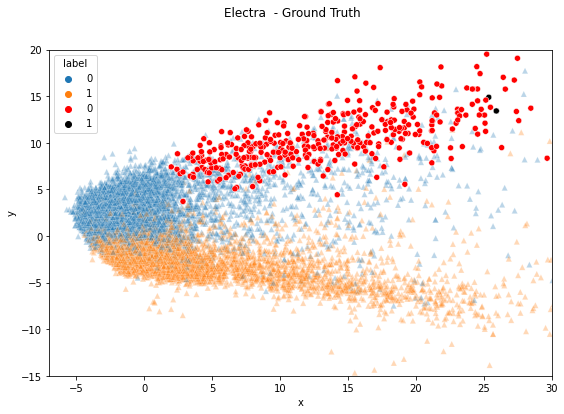

In [90]:
# ys_change_victim = torch.clone(ys_victim)
# ys_change_victim[tst_inds] = 2

# visualize_layerwise_embeddings(hidden_states_victim, masks_victim, ys_change_victim, tst_inds, 
#                                r"Electra $\alpha=2.0$", "electra_model_2.0")

# torch.cuda.empty_cache()
# mem_report()

visualize_layerwise_embeddings(a_hidden_states, a_masks, a_ys.numpy(), tst_inds, 
                               r"Electra  - Ground Truth", "electra_model_2.0_labels",
                               xlim=[-7, 30], ylim=[-15, 20],
                               t_palette=["red", "black"])

visualize_layerwise_embeddings for Electra  - Predictions



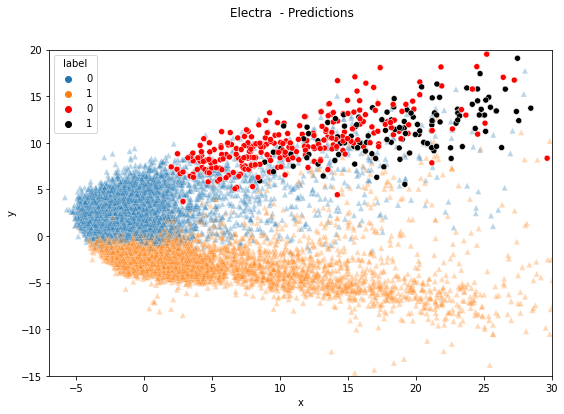

In [91]:
visualize_layerwise_embeddings(a_hidden_states, a_masks, a_predictions, tst_inds, 
                               r"Electra  - Predictions", "electra_model_2.0_pred",
                               xlim=[-7, 30], ylim=[-15, 20],
                               t_palette=["red", "black"])

# Trim Visualization

In [96]:
TRIM_MODEL_PATH = "/content/drive/MyDrive/storage/other/saved_models/victims/imdb_electra_FT_TRM_pois2.0_ind49.ckpt"

In [97]:
trim_model = ElectraForSequenceClassification.from_pretrained(
    "bhadresh-savani/electra-base-emotion",
    output_hidden_states=True,
    output_attentions=True,
    num_labels=2,
    ignore_mismatched_sizes=True
)
trim_model.load_state_dict(torch.load(TRIM_MODEL_PATH, map_location=device))

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at bhadresh-savani/electra-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([6, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [98]:
trim_model.to(device);

In [100]:
acc, loss, hidden_states, masks, ys, predictions = visualize_model(trim_model, eval_dataloader)
print(acc, loss)

plot_values = {}
plot_values["hidden_states"] = hidden_states
plot_values["masks"] = masks
plot_values["ys"] = ys
plot_values["predictions"] = predictions
save_path = "{}/{}".format(SAVE_FOLDER, "electra_trim_plot_values")
np.save(save_path, plot_values)

  Visualizing...


  0%|          | 0/6250 [00:00<?, ?it/s]

CPU RAM Free: 84.6 GB
GPU 0 ... Mem Free: 37090MB / 40536MB | Utilization   9%
CPU RAM Free: 84.7 GB
GPU 0 ... Mem Free: 36978MB / 40536MB | Utilization   9%
0.8905476156785057 tensor(0.2785, device='cuda:0')


In [101]:
save_path = "{}/{}.npy".format(SAVE_FOLDER, "electra_trim_plot_values")
plot_values = np.load(save_path, allow_pickle=True).item()
t_hidden_states = plot_values["hidden_states"]
t_masks = plot_values["masks"]
t_ys = plot_values["ys"]
t_predictions = plot_values["predictions"]

visualize_layerwise_embeddings for Electra TRIM - Ground Truth



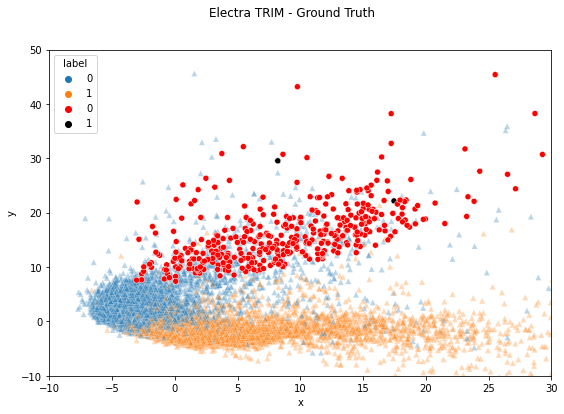

In [110]:
visualize_layerwise_embeddings(t_hidden_states, t_masks, t_ys.numpy(), tst_inds, 
                               r"Electra TRIM - Ground Truth", "electra_model_2.0_trim_labels",
                               xlim=[-10, 30], ylim=[-10, 50],
                               t_palette=["red", "black"])

visualize_layerwise_embeddings for Electra TRIM - Predictions



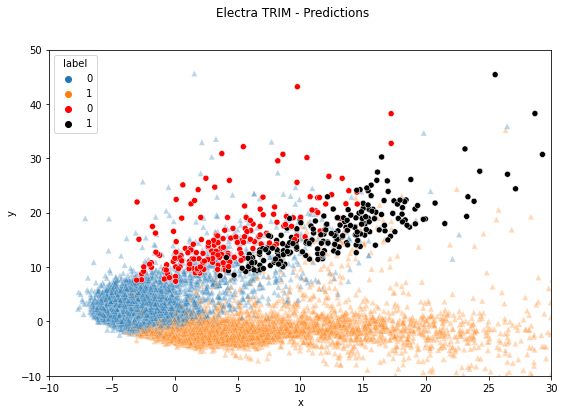

In [111]:
visualize_layerwise_embeddings(t_hidden_states, t_masks, t_predictions, tst_inds, 
                               r"Electra TRIM - Predictions", "electra_model_2.0_trim_pred",
                               xlim=[-10, 30], ylim=[-10, 50],
                               t_palette=["red", "black"])